# Ecological analysis of "The evolution of cooperation (Axelrod & Hamilton, 1981)"

以下は、Axelrod, R., & Hamilton, W. D. (1981). "The evolution of cooperation." Science, 211(4489), 1390–1396. の中で言及されている "Ecological Analysis" を簡易的に再現したものです。

# The model

In [3]:
using Random
using Statistics: mean
using Plots

using Test: @testset, @test

## 1. Define actions and strategies

In [5]:
@enum Action C D

const STRATEGIES = Dict{Symbol, Function}(
    :TIT_FOR_TAT => (history::Vector) -> isempty(history) || history[end] == C ? C : D,
    :ALWAYS_DEFECT => (_) -> D,
    :ALWAYS_COOPERATE => (_) -> C,
    :RANDOM => (_) -> rand([C, D]),
);

## 2. Define the agent

In [7]:
mutable struct Agent
    strategy_name::Symbol
    strategy_func::Function
    history::Vector{Action}
    payoff::Float64

    Agent(strategy_name::Symbol) = new(strategy_name, STRATEGIES[strategy_name], Action[], 0.0)
end

function Base.show(io::IO, agent::Agent)::Nothing
    print(io, "strategy: $(agent.strategy_name), history: $(agent.history), payoff: $(agent.payoff)")
end

function make_agents(populations::Dict{Symbol, Int})::Vector{Agent}
    agents = Agent[]

    for (strategy_name, n) in sort(collect(populations))
        for i in 1:n
            push!(agents, Agent(strategy_name))
        end
    end

    return agents
end

function calc_populations(agents::Vector{Agent})::Dict{Symbol, Int}
    result_dict = Dict(s => 0 for s in keys(STRATEGIES))

    for agent in agents
        result_dict[agent.strategy_name] += 1
    end

    return result_dict
end

function calc_average_payoffs(agents::Vector{Agent})::Dict{Symbol, Float64}
    payoffs = Dict(s => 0.0 for s in keys(STRATEGIES))

    for agent in agents
        payoffs[agent.strategy_name] += agent.payoff
    end

    populations = calc_populations(agents)

    return Dict(s => populations[s] == 0 ? 0.0 : round(payoffs[s] / populations[s], digits=5) for s in keys(STRATEGIES))
end

calc_average_payoff(agents::Vector{Agent})::Float64 = mean([agent.payoff for agent in agents]);

In [8]:
@testset "make_agents" begin
    populations = Dict(:ALWAYS_COOPERATE => 10, :ALWAYS_DEFECT => 20, :TIT_FOR_TAT => 30)
    agents = make_agents(populations)

    @test length(agents) == 60
    @test string(agents[1]) == string(agents[10]) == "strategy: ALWAYS_COOPERATE, history: Action[], payoff: 0.0"
    @test string(agents[11]) == string(agents[30]) == "strategy: ALWAYS_DEFECT, history: Action[], payoff: 0.0"
    @test string(agents[31]) == string(agents[60]) == "strategy: TIT_FOR_TAT, history: Action[], payoff: 0.0"
end

@testset "calc_populations" begin
    populations = Dict(:ALWAYS_COOPERATE => 10, :ALWAYS_DEFECT => 20, :TIT_FOR_TAT => 30)
    agents = make_agents(populations)

    populations = calc_populations(agents)
    @test populations[:ALWAYS_COOPERATE] == 10
    @test populations[:ALWAYS_DEFECT] == 20
    @test populations[:TIT_FOR_TAT] == 30
end

@testset "cals_average_payoffs" begin
    populations = Dict(:ALWAYS_COOPERATE => 10, :ALWAYS_DEFECT => 20, :TIT_FOR_TAT => 30)
    agents = make_agents(populations)

    for (i, agent) in enumerate(agents)
        agent.payoff = i / 10
    end

    average_payoffs = calc_average_payoffs(agents)
    @test average_payoffs[:ALWAYS_COOPERATE] == 0.55
    @test average_payoffs[:ALWAYS_DEFECT] == 2.05
    @test average_payoffs[:TIT_FOR_TAT] == 4.55

    @test calc_average_payoff(agents) == 3.05
end;

Test Summary: | Pass  Total  Time
make_agents   |    4      4  0.2s
Test Summary:    | Pass  Total  Time
calc_populations |    3      3  0.0s
Test Summary:        | Pass  Total  Time
cals_average_payoffs |    4      4  0.0s


## 3. Define the game

In [10]:
const PAYOFF = (
    R = 3.0,  # CC
    T = 5.0,  # DC
    S = 0.0,  # CD
    P = 1.0   # DD
)

function play_game!(agent1::Agent, agent2::Agent)::Nothing
    action1, action2 = agent1.strategy_func(agent2.history), agent2.strategy_func(agent1.history)

    payoff1, payoff2 = if (action1, action2) == (C, C)
        PAYOFF.R, PAYOFF.R
    elseif (action1, action2) == (D, C)
        PAYOFF.T, PAYOFF.S
    elseif (action1, action2) == (C, D)
        PAYOFF.S, PAYOFF.T
    elseif (action1, action2) == (D, D)
        PAYOFF.P, PAYOFF.P
    end

    agent1.payoff += payoff1
    agent2.payoff += payoff2

    push!(agent1.history, action1)
    push!(agent2.history, action2)

    return
end;

In [11]:
@testset "play_game" begin
    agent1 = Agent(:ALWAYS_COOPERATE)
    agent2 = Agent(:ALWAYS_DEFECT)
    play_game!(agent1, agent2)
    @test agent1.payoff == 0.0
    @test agent1.history == [C]
    @test agent2.payoff == 5.0
    @test agent2.history == [D]

    agent1 = Agent(:TIT_FOR_TAT)
    agent2 = Agent(:ALWAYS_COOPERATE)
    agent2.history = [D, C]
    play_game!(agent1, agent2)
    @test agent1.payoff == 3.0
    @test agent1.history == [C]
    @test agent2.payoff == 3.0
    @test agent2.history == [D, C, C]

    agent1 = Agent(:TIT_FOR_TAT)
    agent2 = Agent(:ALWAYS_DEFECT)
    play_game!(agent1, agent2)
    @test agent1.payoff == 0.0
    @test agent1.history == [C]
    @test agent2.payoff == 5.0
    @test agent2.history == [D]

    play_game!(agent1, agent2)
    @test agent1.payoff == 1.0
    @test agent1.history == [C, D]
    @test agent2.payoff == 6.0
    @test agent2.history == [D, D]
end;

Test Summary: | Pass  Total  Time
play_game     |   16     16  0.0s


## 4. Define the simulation

In [13]:
function make_agent_pair_vec(agents::Vector{Agent})::Vector{Tuple{Agent, Agent}}
    agent_count = length(agents)
    if agent_count % 2 != 0
        agent_count -= 1
    end

    agent_id_vec = shuffle(collect(1:agent_count))
    agent_pair_vec = [(agents[agent_id_vec[i]], agents[agent_id_vec[i+1]]) for i in 1:2:agent_count]
end

function run_one_generation!(agents::Vector{Agent}, round_num::Int = 100)::Vector{Agent}
    for (agent1, agent2) in make_agent_pair_vec(agents)
        for _ in 1:round_num
            play_game!(agent1, agent2)
        end
    end

    # update strategy
    populations = calc_populations(agents)
    average_payoffs = calc_average_payoffs(agents)
    average_payoff = calc_average_payoff(agents)

    for s in keys(STRATEGIES)
        populations[s] = round(Int, (average_payoffs[s] / average_payoff) * populations[s])
    end

    return make_agents(populations)
end;

In [14]:
function run!(agents::Vector{Agent}; trial_num = 1, generation_num::Int = 100, round_num::Int = 100)::Dict{Symbol, Matrix{Int}}
    population_transition = Dict(s => fill(0, trial_num, generation_num + 1) for s in keys(STRATEGIES))
    populations = calc_populations(agents)
    for s in keys(STRATEGIES)
        for trial in 1:trial_num
            population_transition[s][trial, 1] = populations[s]
        end
    end

    for trial in 1:trial_num
        for generation in 2:(generation_num + 1)
            agents = run_one_generation!(agents, round_num)
            populations = calc_populations(agents)
    
            for s in keys(STRATEGIES)
                population_transition[s][trial, generation] = populations[s]
            end
        end
    end

    return population_transition
end

populations = Dict(strategy => 100 for strategy in keys(STRATEGIES))
agents = make_agents(populations)
population_transition = run!(agents)

Dict{Symbol, Matrix{Int64}} with 4 entries:
  :ALWAYS_DEFECT    => [100 115 … 0 0]
  :RANDOM           => [100 102 … 1 1]
  :TIT_FOR_TAT      => [100 101 … 382 382]
  :ALWAYS_COOPERATE => [100 82 … 12 12]

## 5. Visualization

In [16]:
default(
    fontfamily="Arial",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    dpi=600,
);

In [17]:
function line_color(strategy_name::Symbol)::String
    return if strategy_name == :ALWAYS_COOPERATE
        "#3261AB"
    elseif strategy_name == :TIT_FOR_TAT
        "#23AC0E"
    elseif strategy_name == :ALWAYS_DEFECT
        "#C7243A"
    elseif strategy_name == :RANDOM
        "#000000"
    end
end

function plot_lines(population_transition::Dict{Symbol, Matrix{Int}})::Plots.Plot
    p = plot(
        title = "Ecological Analysis",
        xlabel = "Generation",
        xticks = 0:10:100,
        ylabel = "Frequency of each strategy",
        ylim = (-0.05, 1.05),
        yticks = 0:0.1:1,
        legend = :right,
    )

    total_pop = sum([population_transition[strategy][1, 1] for strategy in keys(STRATEGIES)])

    for strategy in sort(collect(keys(STRATEGIES)))
        trial_num, generation_num = size(population_transition[strategy])
        for trial in 1:trial_num
            plot!(population_transition[strategy][trial, :] ./ total_pop, label = "$(strategy)", lw = 2, lc = line_color(strategy))
        end
    end

    return p
end;

# Results

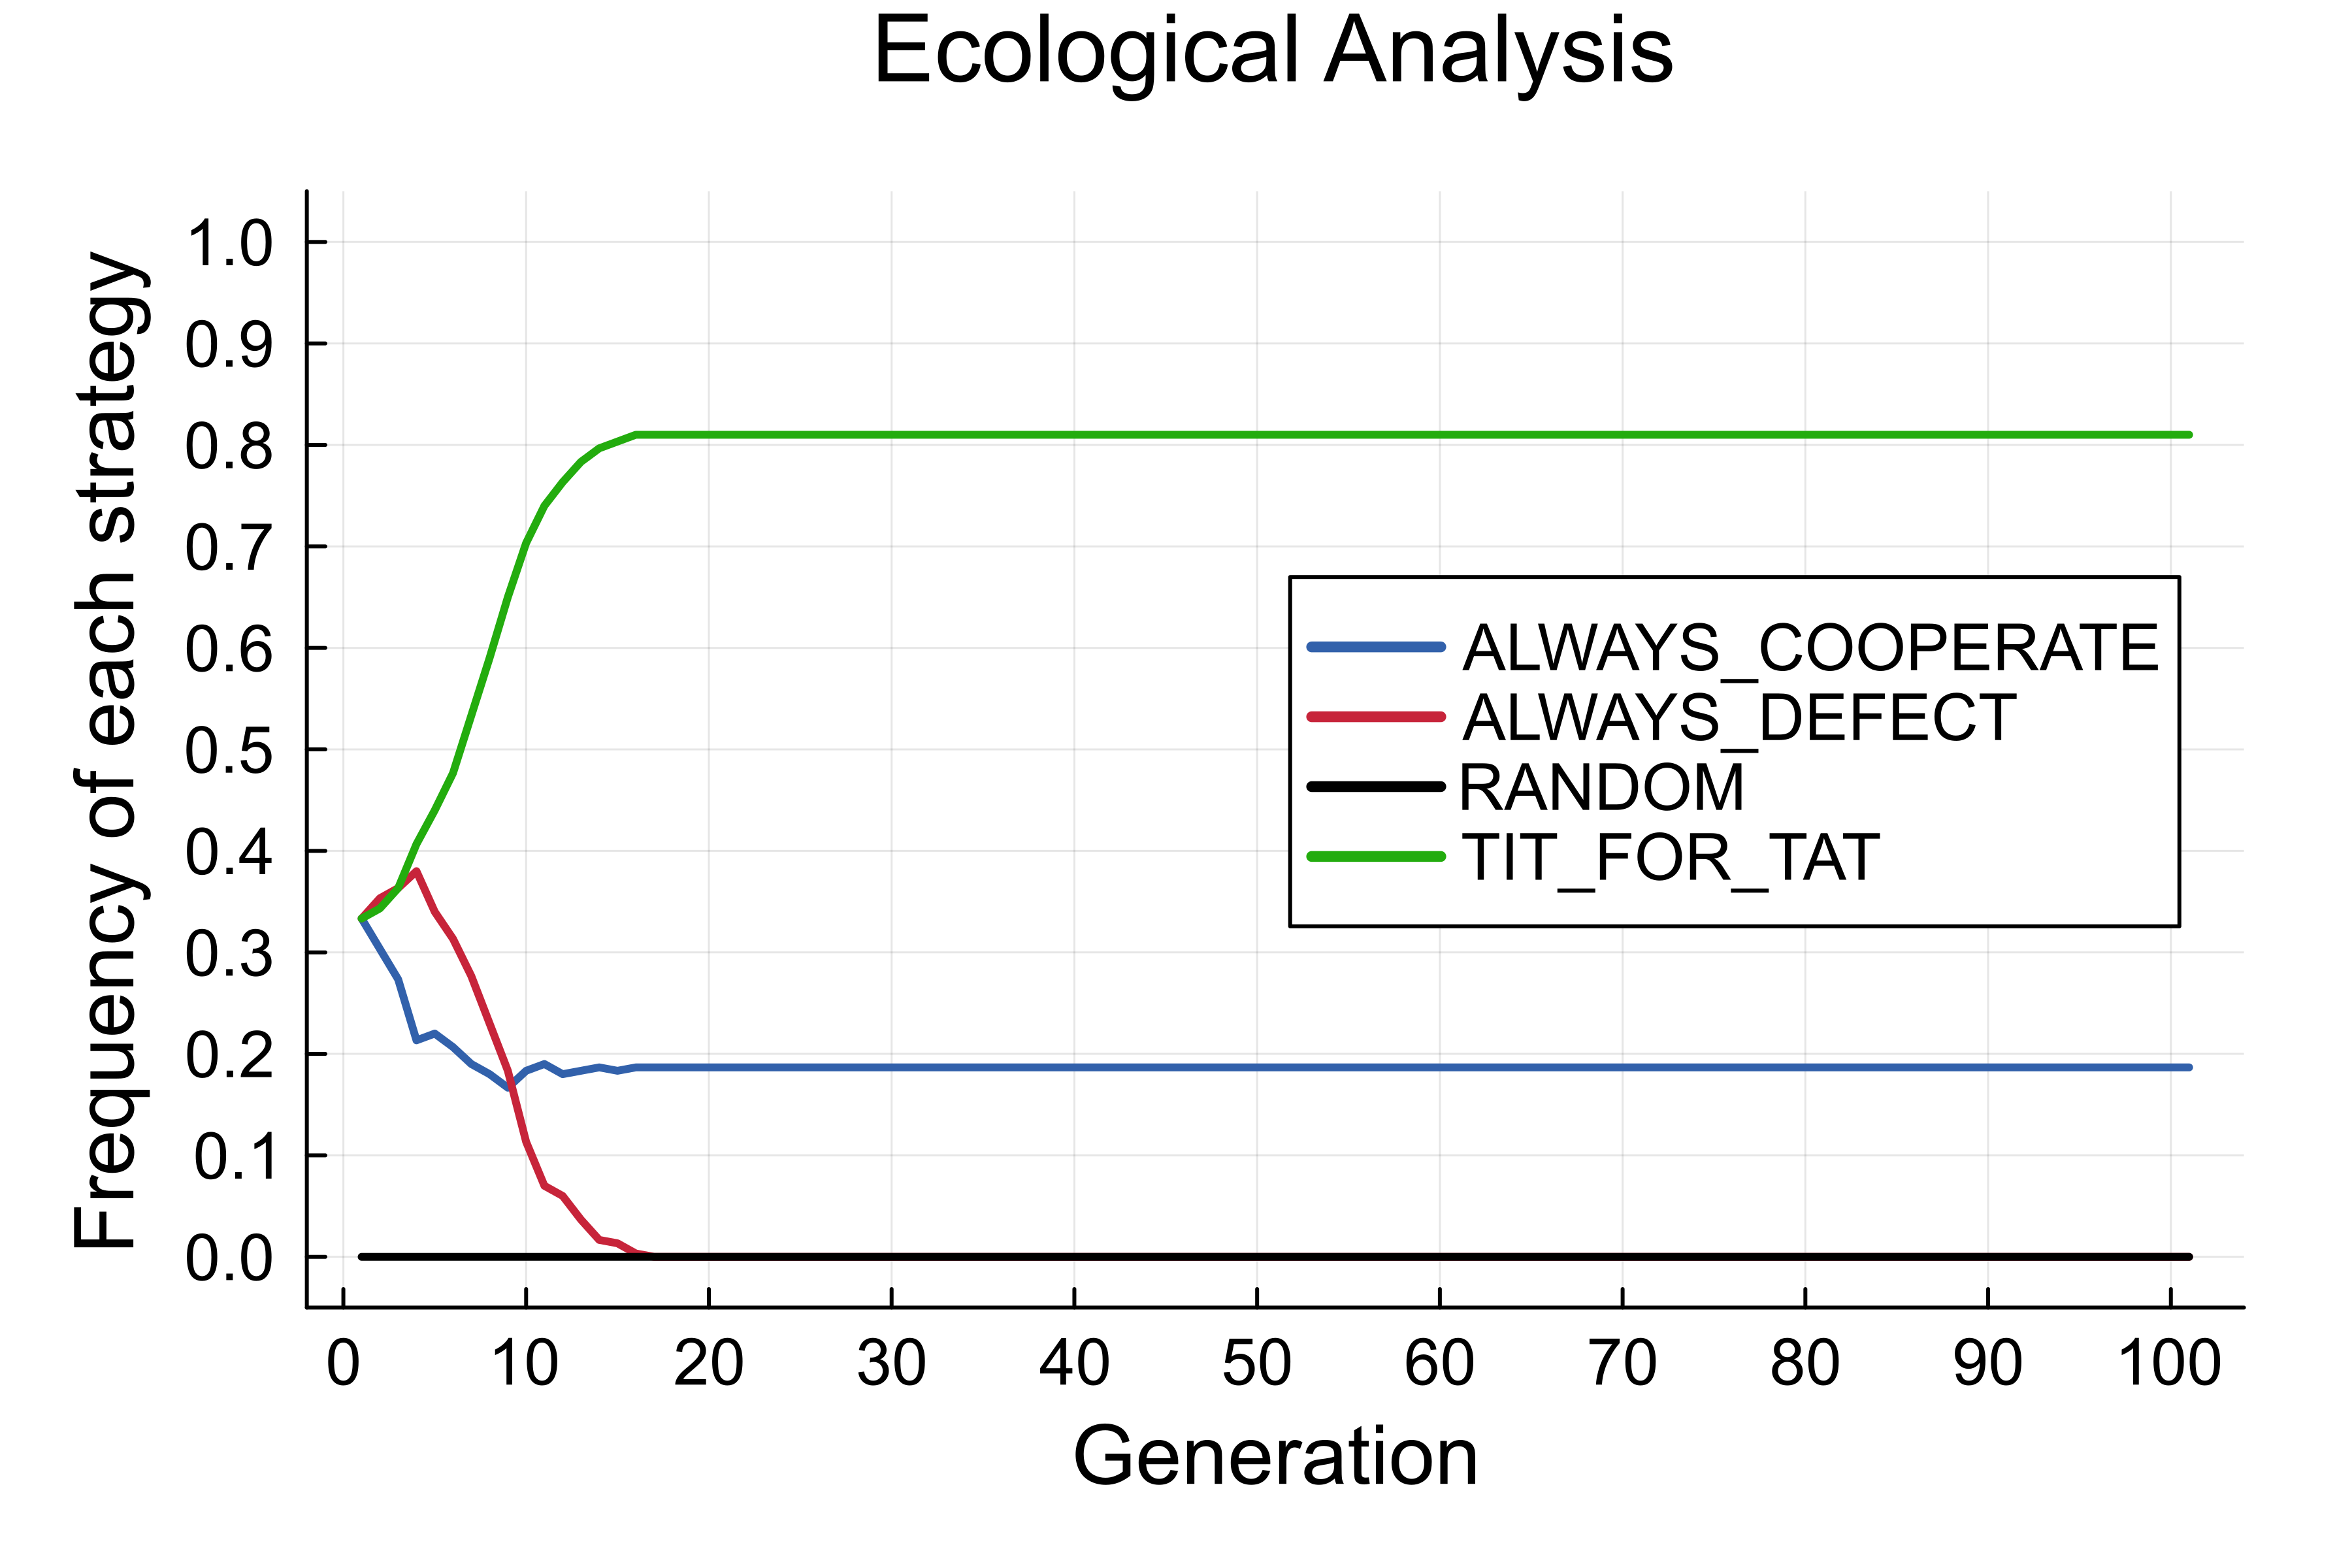

In [19]:
populations = Dict(
    :TIT_FOR_TAT => 100,
    :ALWAYS_DEFECT => 100,
    :ALWAYS_COOPERATE => 100,
    :RANDOM => 0,
)

populations |> make_agents |> run! |> plot_lines
# savefig("Fig1a.png")

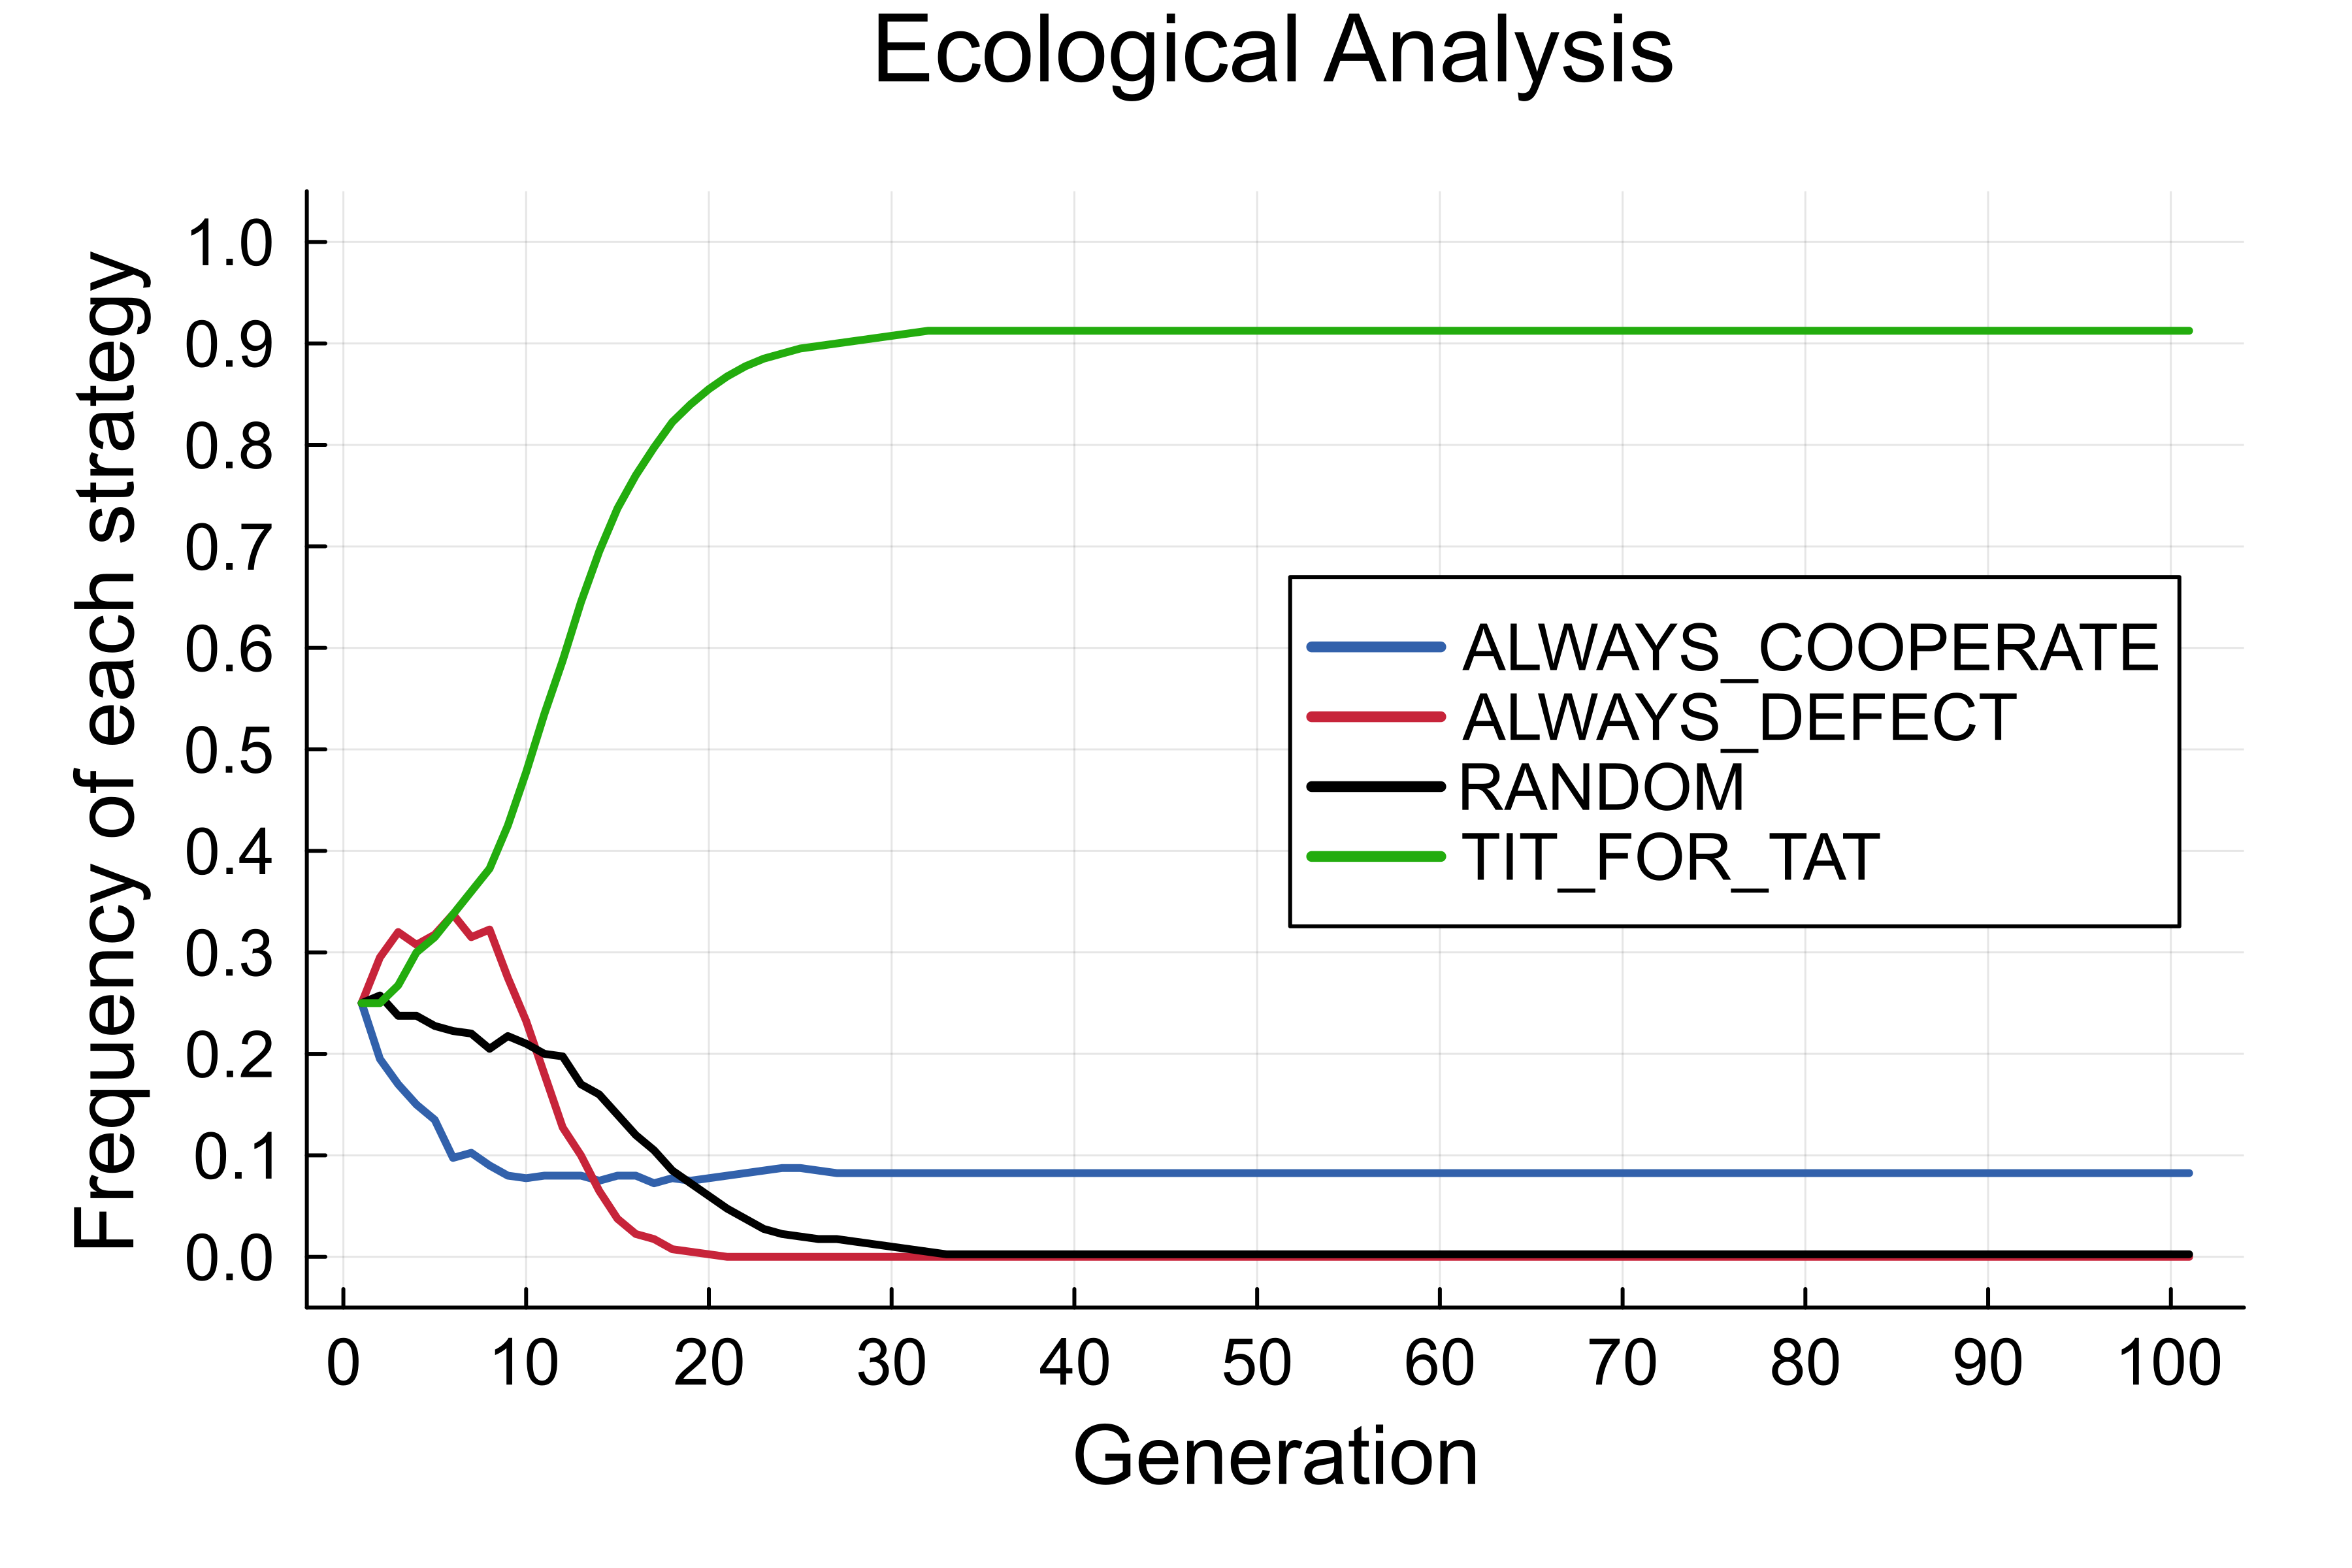

In [20]:
populations = Dict(
    :TIT_FOR_TAT => 100,
    :ALWAYS_DEFECT => 100,
    :ALWAYS_COOPERATE => 100,
    :RANDOM => 100,
)

populations |> make_agents |> run! |> plot_lines
# savefig("Fig1b.png")

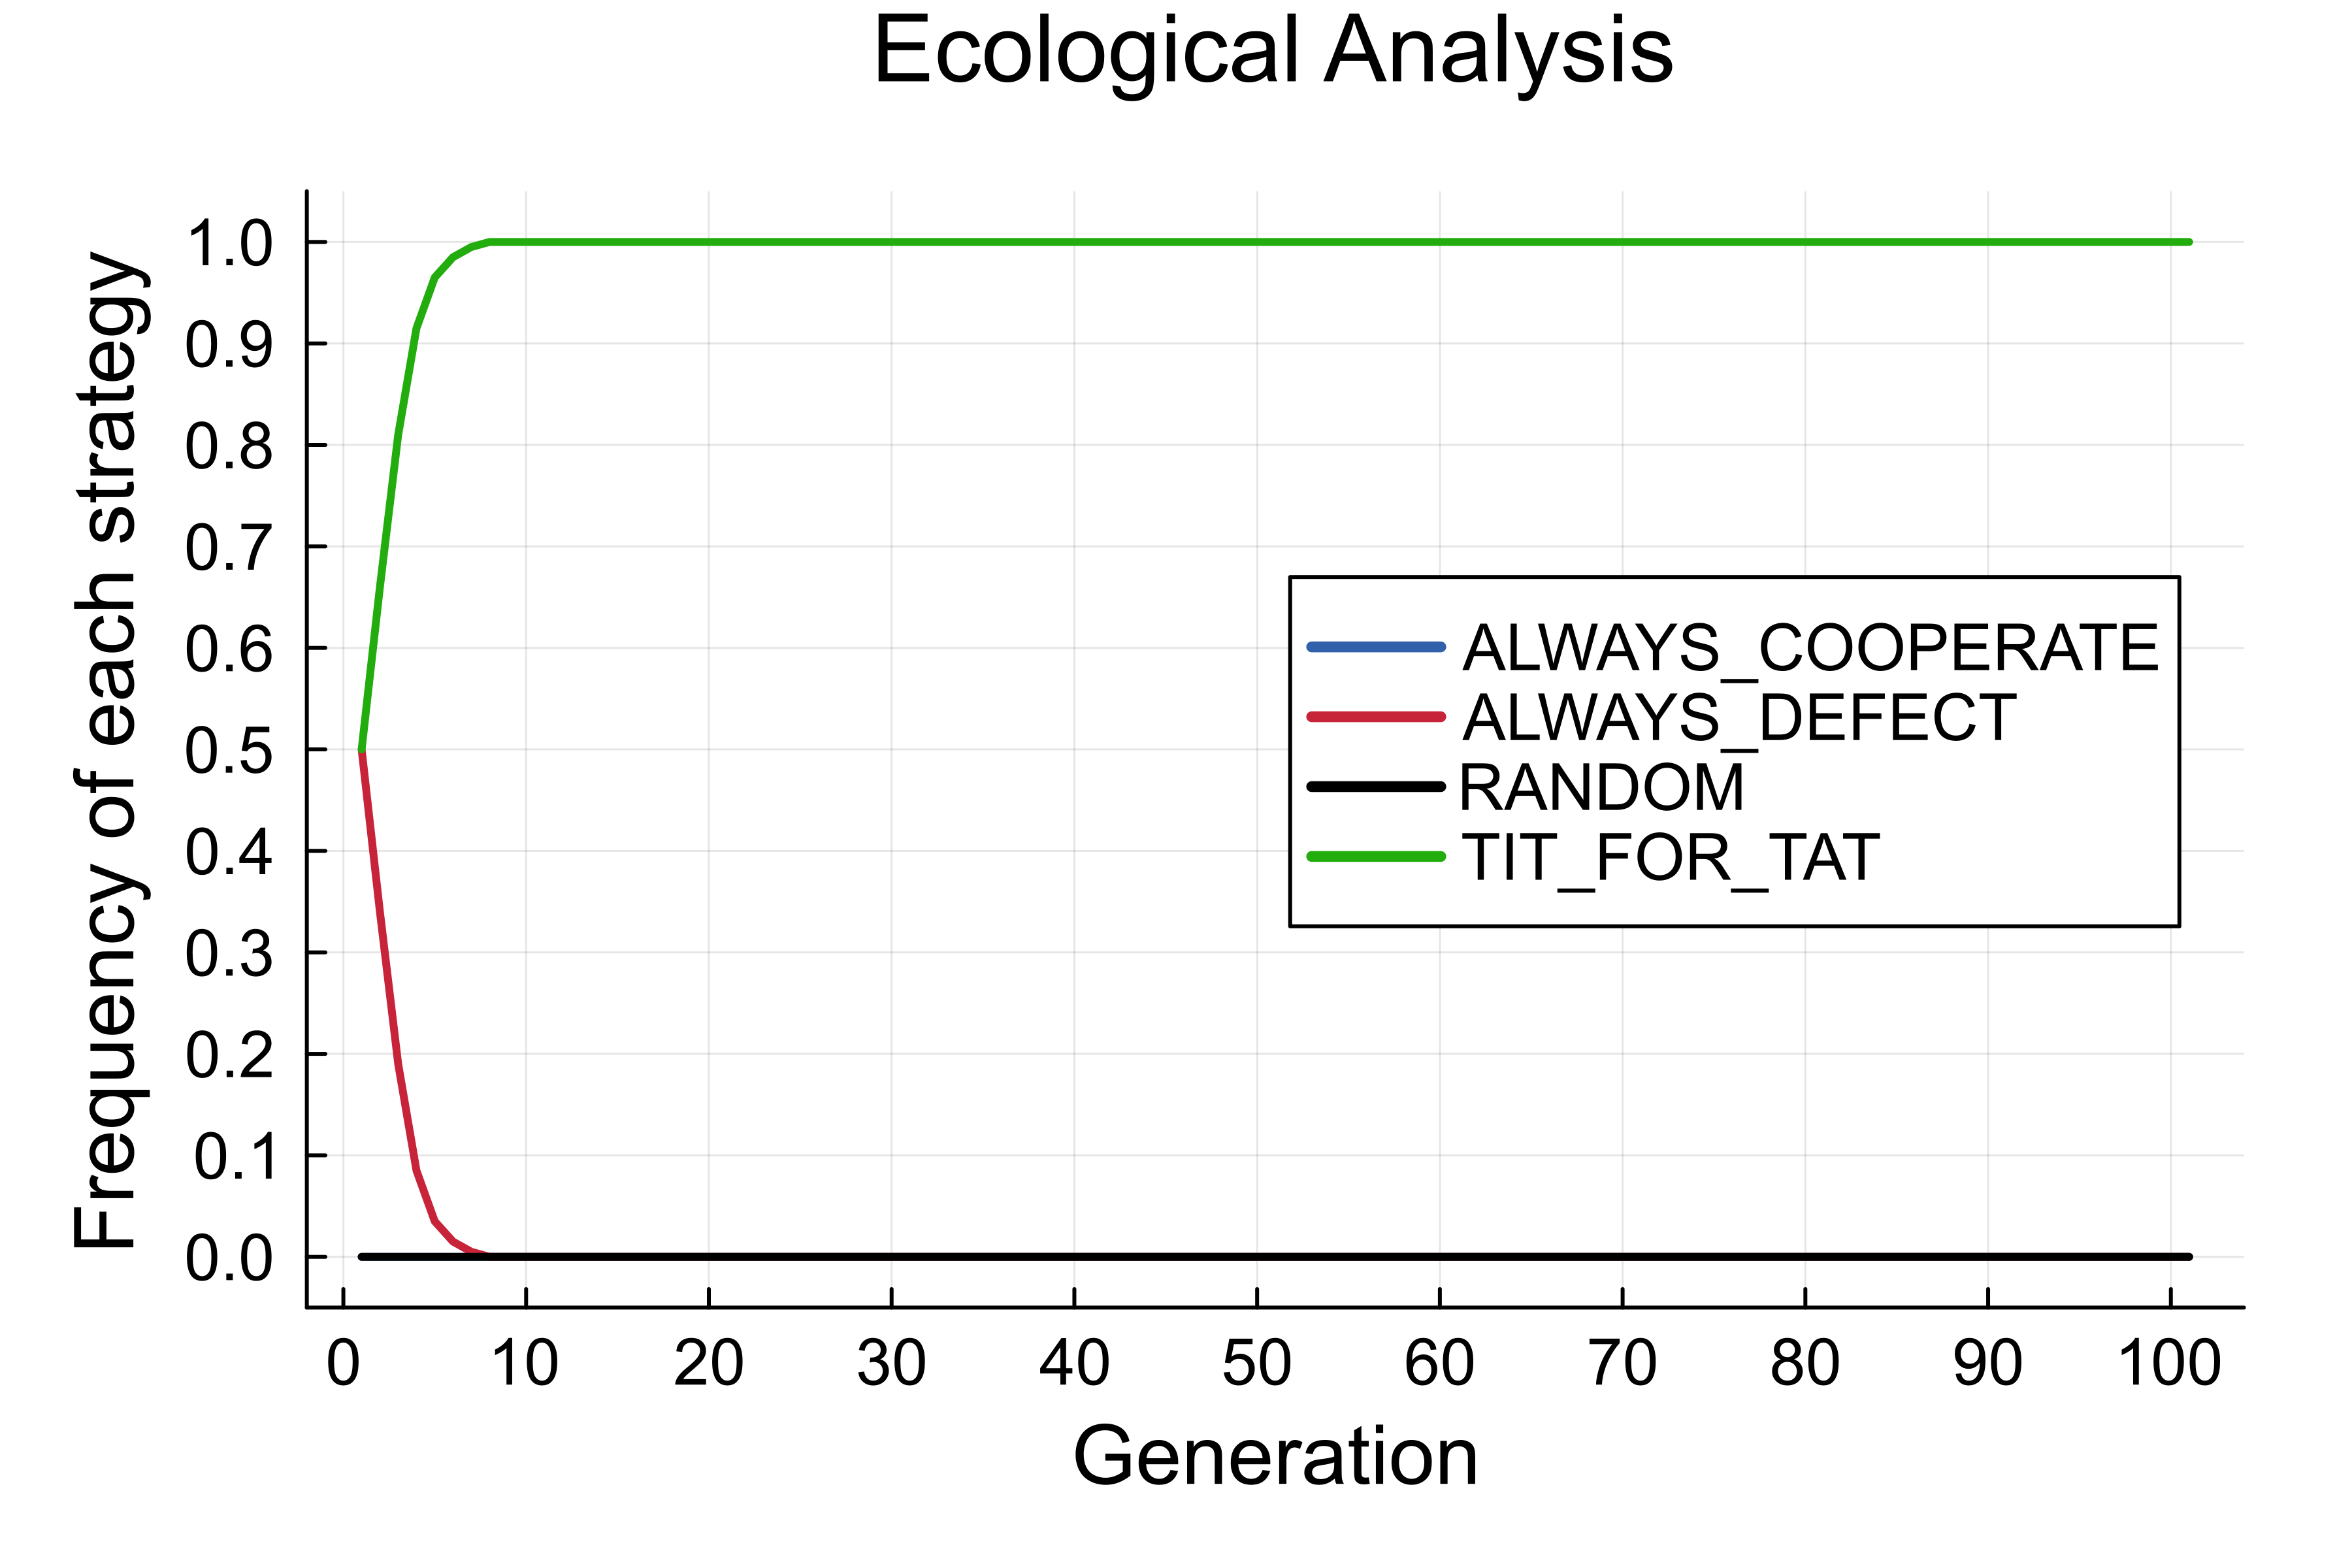

In [21]:
populations = Dict(
    :TIT_FOR_TAT => 100,
    :ALWAYS_DEFECT => 100,
    :ALWAYS_COOPERATE => 0,
    :RANDOM => 0,
)

populations |> make_agents |> run! |> plot_lines
# savefig("Fig1c.png")

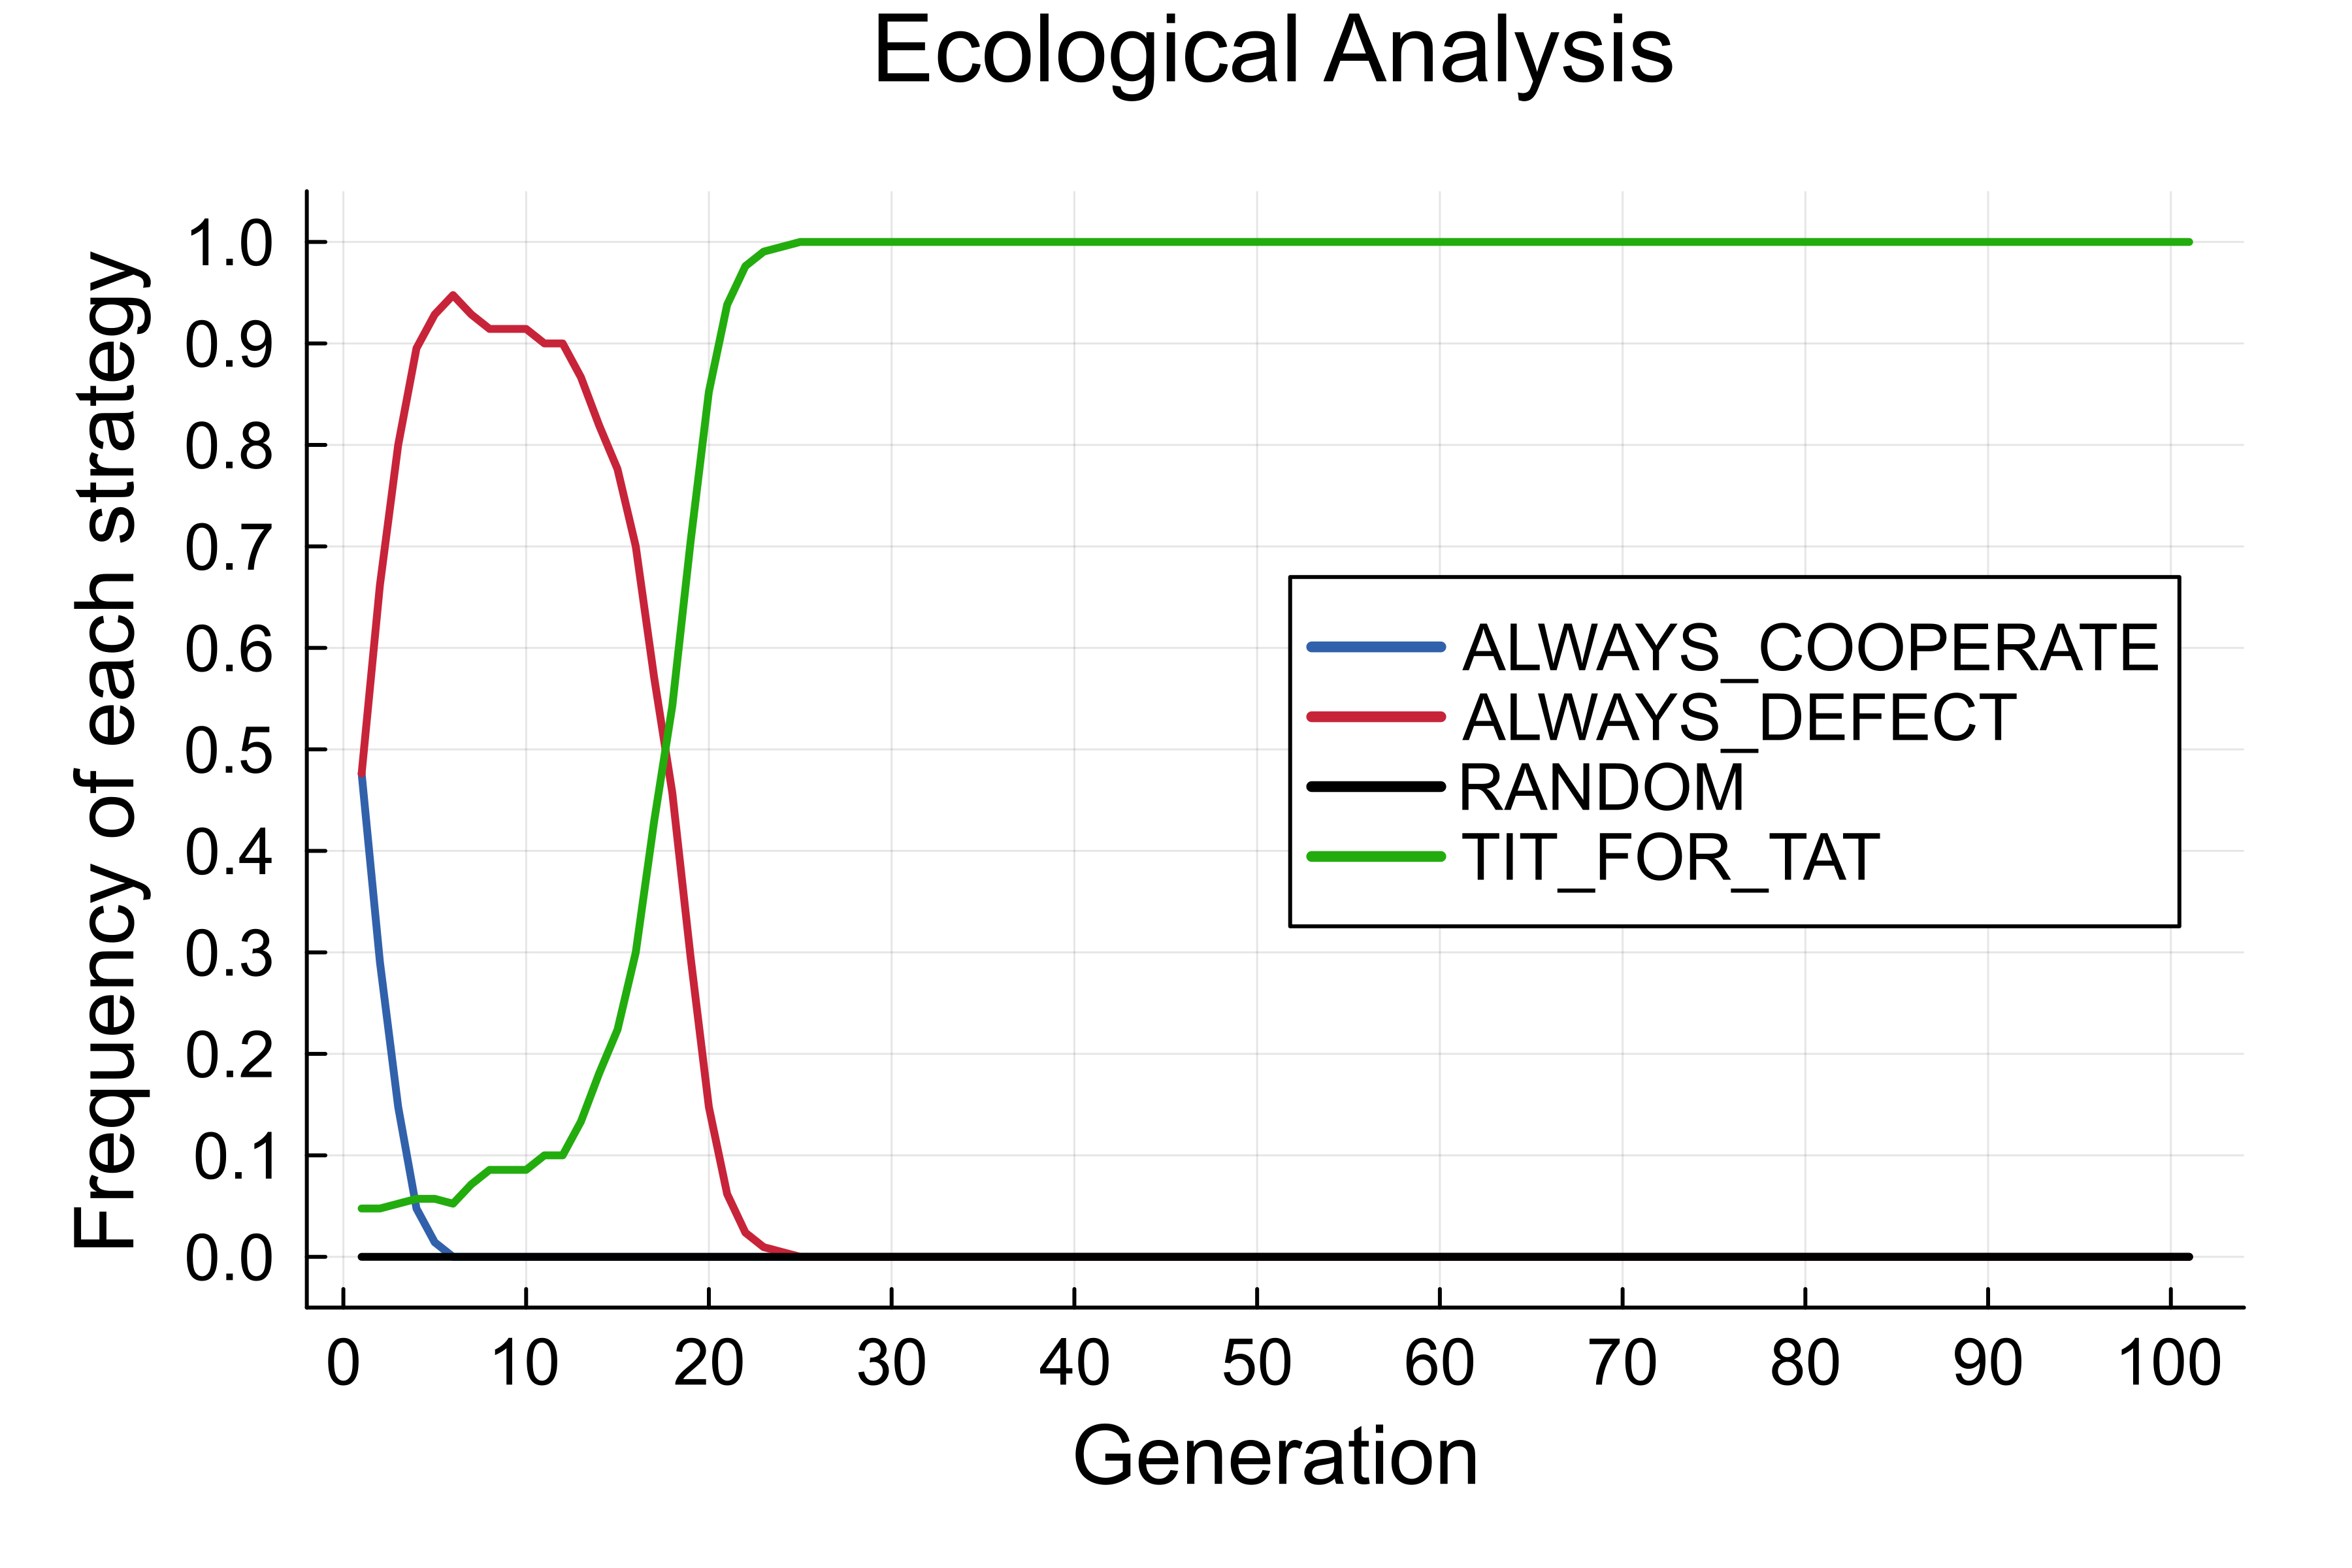

In [42]:
populations = Dict(
    :TIT_FOR_TAT => 10,
    :ALWAYS_DEFECT => 100,
    :ALWAYS_COOPERATE => 100,
    :RANDOM => 0,
)

populations |> make_agents |> run! |> plot_lines
# savefig("Fig1d.png")